baseline model:
AlexNet + transfer learning (mixed datasets)

all the hyperparameters are the same as in the paper

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset

from torch import nn, optim
from torchvision import models

Mounted at /content/drive


In [ ]:
# Paths
root_dir = '/content/drive/MyDrive/plant_village_dataset'
train = os.path.join(root_dir, 'train_downsampled')
val = os.path.join(root_dir, 'val_downsampled')



# Transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])



In [ ]:
#  Load datasets
train_dataset = datasets.ImageFolder(train, transform=transform)
val_dataset = datasets.ImageFolder(val, transform=transform)



# Dataloaders
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
# Load pretrained AlexNet + TL weights
alexnet = models.alexnet(pretrained=True)

# Get the number of classes from the dataset 
num_classes = len(train_dataset.classes)

alexnet.classifier[6] = nn.Linear(4096, num_classes) 

alexnet.load_state_dict(torch.load("/content/drive/MyDrive/plant_village_dataset/alexnet_tl_epoch_20.pth"))

# Freeze all feature layers
for param in alexnet.features.parameters():
    param.requires_grad = False

# Unfreeze last two convolutional blocks
for param in alexnet.features[10].parameters():
    param.requires_grad = True

for param in alexnet.features[12].parameters():
    param.requires_grad = True

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet = alexnet.to(device)

# Loss and optimizer (fine-tune only unfrozen parameters), same as in paper
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    filter(lambda p: p.requires_grad, alexnet.parameters()),
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

epochs = 30

Epoch 1/30 | Train Loss: 0.0612, Train Acc: 0.9820 | Val Loss: 0.2699, Val Acc: 0.9252
Epoch 2/30 | Train Loss: 0.0647, Train Acc: 0.9798 | Val Loss: 0.2766, Val Acc: 0.9209
Epoch 3/30 | Train Loss: 0.0470, Train Acc: 0.9869 | Val Loss: 0.2623, Val Acc: 0.9252
Epoch 4/30 | Train Loss: 0.0361, Train Acc: 0.9887 | Val Loss: 0.2680, Val Acc: 0.9317
Epoch 5/30 | Train Loss: 0.0319, Train Acc: 0.9913 | Val Loss: 0.2724, Val Acc: 0.9317
Saved checkpoint at epoch 5 → /content/drive/MyDrive/plant_village_dataset/alexnet_ft_epoch_5.pth
Epoch 6/30 | Train Loss: 0.0271, Train Acc: 0.9919 | Val Loss: 0.2523, Val Acc: 0.9348
Epoch 7/30 | Train Loss: 0.0262, Train Acc: 0.9926 | Val Loss: 0.2639, Val Acc: 0.9309
Epoch 8/30 | Train Loss: 0.0224, Train Acc: 0.9937 | Val Loss: 0.2684, Val Acc: 0.9348
Epoch 9/30 | Train Loss: 0.0206, Train Acc: 0.9945 | Val Loss: 0.2821, Val Acc: 0.9317
Epoch 10/30 | Train Loss: 0.0188, Train Acc: 0.9958 | Val Loss: 0.2666, Val Acc: 0.9330
Saved checkpoint at epoch 10 → 

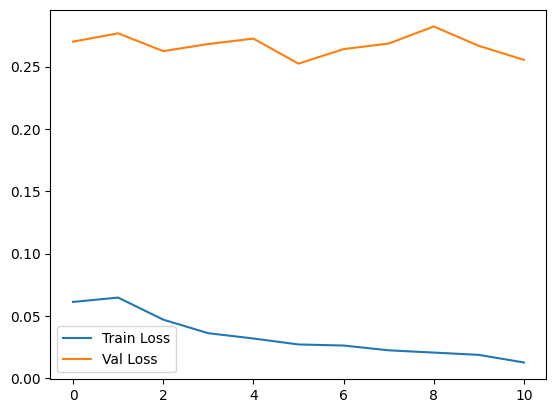

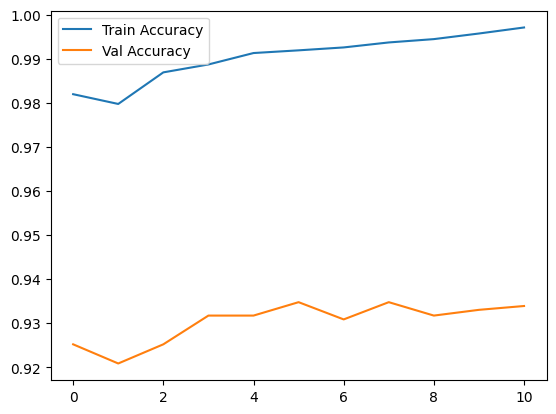

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

early_stop_patience = 5 #stop training after 5 epochs of no improvement
best_val_loss = float("inf")
epochs_without_improvement = 0

save_every = 5 #keep checkpoints

for epoch in range(epochs):
    alexnet.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    total_batches = 0


    # Training

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = alexnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_batches += 1

        _, preds = outputs.max(1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    epoch_train_loss = running_loss / total_batches
    epoch_train_acc = correct_train / total_train

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)


    # Validation

    alexnet.eval()
    val_loss_sum = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = alexnet(images)
            loss = criterion(outputs, labels)

            val_loss_sum += loss.item()
            _, preds = outputs.max(1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    epoch_val_loss = val_loss_sum / len(val_loader)
    epoch_val_acc = correct_val / total_val

    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)


    # Early Stopping + Saving best model

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_without_improvement = 0

        # Save model weights 
        torch.save(
            alexnet.state_dict(),
            "/content/drive/MyDrive/plant_village_dataset/alexnet_ft_best_weights.pth"
        )
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stop_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break


    # Step LR scheduler

    scheduler.step()

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")


    # Saving checkpoints periodically (to avoid running time issues)

    if (epoch + 1) % save_every == 0:
        save_path = f"/content/drive/MyDrive/plant_village_dataset/alexnet_ft_epoch_{epoch+1}.pth"

        torch.save({
            "epoch": epoch + 1,
            "model_state": alexnet.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": scheduler.state_dict(),
            "train_losses": train_losses,
            "val_losses": val_losses,
            "train_accuracies": train_accuracies,
            "val_accuracies": val_accuracies
        }, save_path)

        print(f"Saved checkpoint at epoch {epoch+1} → {save_path}")

# Final Save
torch.save({
    "epoch": epoch + 1,
    "model_state": alexnet.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "scheduler_state": scheduler.state_dict(),
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accuracies": train_accuracies,
    "val_accuracies": val_accuracies
}, "/content/drive/MyDrive/plant_village_dataset/alexnet_ft_final.pth")

print("Final model saved")



import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.show()


plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.show()
